# Feature Selection

## Importing Libraries and importing dataset

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from skfeature.function.similarity_based import fisher_score
%matplotlib inline

#data = pd.read_csv('dataset/roi_95img_9_roi_glrlm_32p.csv')
train = pd.read_csv('dataset/train.csv', index_col='name')

X_train = train.copy()
y_train = X_train.pop('target')
#std = StandardScaler()
#std.fit(X_train)
#X_trains = pd.DataFrame(std.transform(X_train), columns=X_train.columns)
X_train.columns


Index(['10Percentile', '90Percentile', 'Autocorrelation', 'ClusterProminence',
       'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation',
       'DifferenceAverage', 'DifferenceEntropy',
       ...
       'homogeneity_d1_45', 'homogeneity_d1_90', 'homogeneity_d2_0',
       'homogeneity_d2_135', 'homogeneity_d2_45', 'homogeneity_d2_90',
       'homogeneity_d3_0', 'homogeneity_d3_135', 'homogeneity_d3_45',
       'homogeneity_d3_90'],
      dtype='object', length=107)

<AxesSubplot:xlabel='Features', ylabel='Accuracy'>

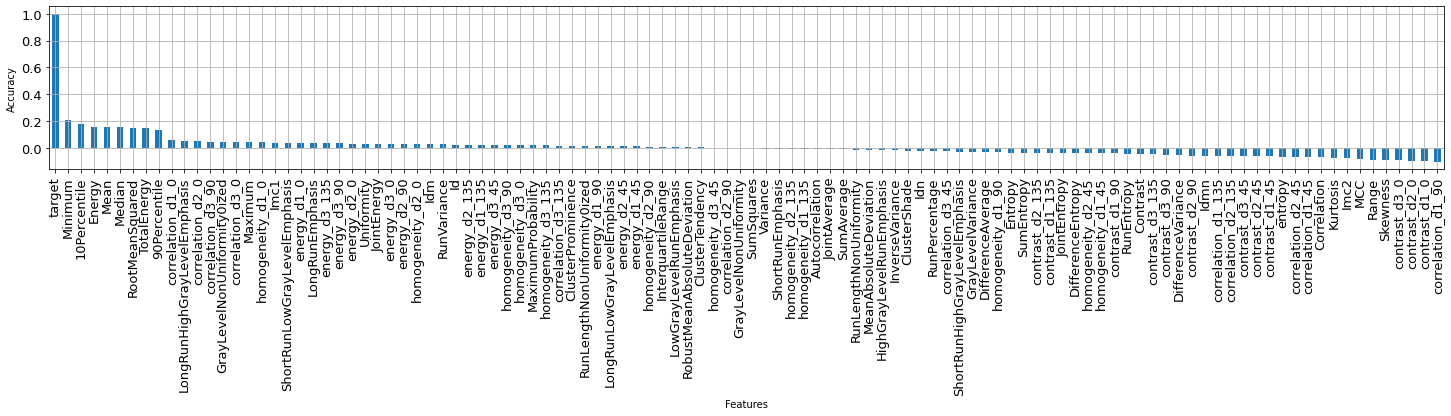

In [56]:
trains = pd.read_csv('dataset/trains.csv', index_col='name')
corrmatrix = trains.corrwith(trains["target"])
corrmatrix.sort_values(ascending=False, inplace=True)
# corrmatrix.plot(kind='barh', color='r', alpha=0.5)
corrmatrix.plot(xlabel='Features',ylabel="Accuracy",kind="bar", legend=False, figsize=(25,3), fontsize=13, grid=True)
# train.columns

# corr_matrix = train.corr()

# Fisher's Score

In [29]:
# jundongl /scikit-feature
# https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/similarity_based/fisher_score.py

import numpy as np
from scipy.sparse import *
from skfeature.utility.construct_W import construct_W


def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [30]:
X = X_train.to_numpy()
Y = y_train.to_numpy()

score = fisher_score(X, Y)
print(score)



[0.1629677  0.15145961 0.04543857 0.00033435 0.00350496 0.00547253
 0.03413415 0.00796525 0.03743359 0.0309354  0.02775301 0.16505651
 0.02067744 0.03100367 0.01700868 0.00348917 0.03409946 0.03818261
 0.03804336 0.01244174 0.03474307 0.00863173 0.00693588 0.02842413
 0.03859532 0.0500406  0.02595757 0.02804907 0.01670018 0.02082355
 0.00727578 0.01886575 0.03993788 0.01098105 0.03956955 0.02958682
 0.16976166 0.02041941 0.17660214 0.12618536 0.01060717 0.02601432
 0.16782004 0.00431786 0.03461986 0.00713245 0.03847083 0.0172369
 0.0203581  0.02755897 0.01616643 0.08952557 0.0500406  0.02396635
 0.00868475 0.0347061  0.02214598 0.00889591 0.04911281 0.04248406
 0.01441701 0.02907835 0.05209696 0.04248406 0.01441701 0.02406681
 0.05028331 0.02736035 0.01310276 0.01744439 0.03520606 0.01321904
 0.00495139 0.01233064 0.04277581 0.01321904 0.00495139 0.00461782
 0.04498306 0.01321169 0.00075252 0.00868099 0.0628596  0.03678111
 0.03325879 0.03381046 0.04957073 0.03678111 0.03325879 0.03413

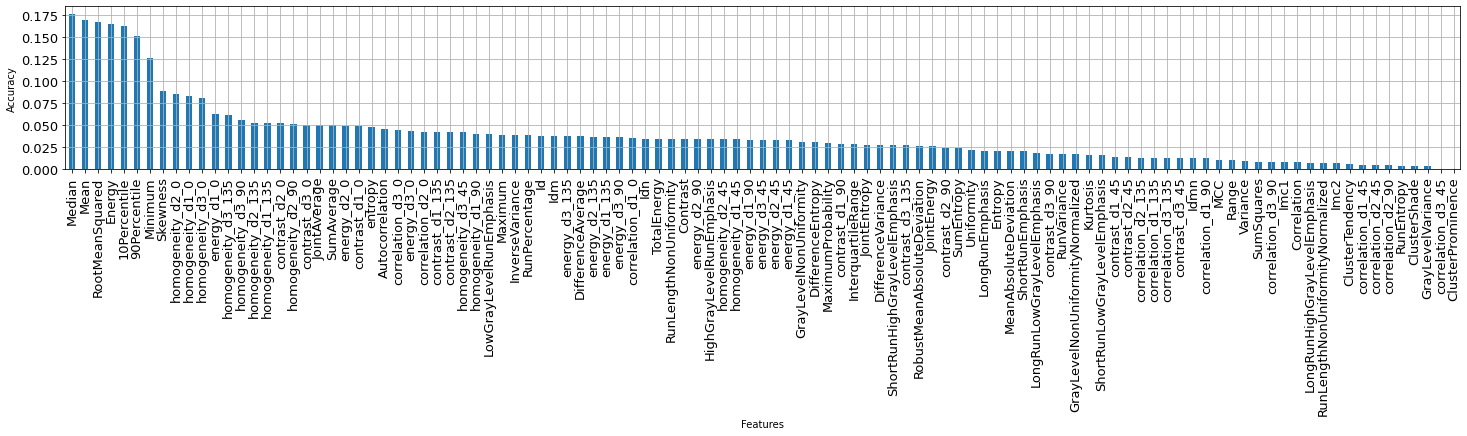

In [31]:
frame = pd.Series(score,index = X_train.columns)
frame.idxmax()
frame.sort_values(ascending=False, inplace=True)
frame.plot(xlabel='Features',ylabel="Accuracy",kind="bar", legend=False, figsize=(25,3), fontsize=13, grid=True)
plt.show()

In [5]:
idx = feature_ranking(score)

print(idx)

[ 38  36 107  42  11   0   1  39  51  99  95 103  82 104 106 100  96  62
 102  66  25  52  86  58  94   2  78  90  74  59  63 105  98  32  34  24
  46  17  18  91   8  87  83  93  70  20  55  44   6  89  16  97 101  85
  92  88  84  13   9  35  61  23  27  10  49  67  41  26  65  53  56  29
  12  37  48  31  69  47  14  28  50  60  64  71  75  79  68  19  73  33
  40 108  57  54  81  21   7  30  45  22   5  72  76  77  43   4  15  80
   3]


In [13]:
X_train.columns[42]

'RootMeanSquared'

In [18]:
num_fea = 1
selected_features_train = X[:, idx[0:num_fea]]
selected_features_test = X[:, idx[0:num_fea]]
print(selected_features_train)

[[64.]
 [75.]
 [73.]
 ...
 [84.]
 [92.]
 [97.]]


In [ ]:
X = X_train.to_numpy()
Y = y_train.to_numpy()


ranks = fisher_score.fisher_score(X,Y,mode='index')

#remove first 30 features
dropped_columns = ranks[30:]
cols = train.columns
fishertrain = train.copy()
for i in range(len(dropped_columns)):
    fishertrain = fishertrain.drop(cols[dropped_columns[i]],axis = 1)

# fishertrain.to_csv('dataset/fishertrain.csv',index= False)

test = pd.read_csv('dataset/test.csv', index_col='name')
cols = test.columns
fishertest = test.copy()
for i in range(len(dropped_columns)):
    fishertest = fishertest.drop(cols[dropped_columns[i]],axis = 1)

# fishertest.to_csv('dataset/fishertest.csv',index= False)    

In [ ]:
feat_importance = pd.Series(ranks,X_train.columns[0:len(X_train.columns)])
plt.figure(figsize=(13, 13), dpi=80)
plt.xlabel('Fisher\'s Score', fontsize=40)
feat_importance.plot(kind='barh',color='teal')
plt.show()

# Correlation Matrix

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr, corr_matrix

In [ ]:
correlation_train = train.copy()
correlation_test = test.copy()
corr_features, corr_matrix = correlation(correlation_train, 0.7)


In [ ]:
plt.figure(figsize=(100,100))
sns.heatmap(corr_matrix, annot=True)

In [ ]:
correlation_train = correlation_train.drop(corr_features,axis=1)
correlation_test = correlation_test.drop(corr_features,axis=1)
correlation_test.to_csv('dataset/corrtest.csv' ,index= False)    
correlation_train.to_csv('dataset/corrtrain.csv',index= False)    

In [5]:
X_train.columns

Index(['10Percentile', '90Percentile', 'Autocorrelation', 'ClusterProminence',
       'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation',
       'DifferenceAverage', 'DifferenceEntropy',
       ...
       'homogeneity_d1_45', 'homogeneity_d1_90', 'homogeneity_d2_0',
       'homogeneity_d2_135', 'homogeneity_d2_45', 'homogeneity_d2_90',
       'homogeneity_d3_0', 'homogeneity_d3_135', 'homogeneity_d3_45',
       'homogeneity_d3_90'],
      dtype='object', length=107)

# Mutual Information Score

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def make_mi_scores(X, y):
    X = X.copy()
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
mi_scores = make_mi_scores(X_train, y_train)

plt.figure(dpi=100, figsize=(8, 15))
plot_mi_scores(mi_scores)

In [ ]:
threshold = 0.6
cols_to_remove = []
for key in mi_scores.keys():
    if mi_scores[key] < 0.6:
        cols_to_remove.append(key)
        
mi_train = train.drop(columns=cols_to_remove)
mi_test = test.drop(columns=cols_to_remove)
mi_test.to_csv('dataset/mi_test.csv' ,index= False)    
mi_train.to_csv('dataset/mi_train.csv',index= False)    